# Data Exploration using Scanpy

In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
import anndata
DATA_PATH = "/media/gambino/students_workdir/ibp/combined_filtered_counts_13_11.h5"
NORMALIZED_SAMPLES_DATA_PATH = "/media/gambino/students_workdir/ibp/combined_normalizedpersample_qced_filtered_counts_13_11.h5"
NORMALIZED_SAMPLES_GLOBAL_DATA_PATH = "/media/gambino/students_workdir/ibp/combined_normalizedpersampleglobal_qced_filtered_counts_13_11.h5"
NORMALIZED_GLOBAL_DATA_PATH = "/media/gambino/students_workdir/ibp/combined_normalizedglobal_qced_filtered_counts_13_11.h5"

sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
brotli                      1.0.9
certifi                     2023.11.17
cffi                        1.15.1
charset_normalizer          2.0.4
comm                        0.2.0
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.0
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
get_annotations             NA
h5py                        3.10.0
idna                        3.4
igraph                      0.10.8
importlib_resources         NA
ipykernel                   6.26.0
ipywidge

In [5]:
adata = anndata.read(NORMALIZED_SAMPLES_GLOBAL_DATA_PATH)
adata.layers["raw_counts"]=adata.X
adata.X= adata.layers["log1p_norm"]
adata

AnnData object with n_obs × n_vars = 126805 × 36601
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'predicted_doublets', 'doublet_scores'
    var: 'gene_ids', 'feature_types', 'genome', 'mt'
    layers: 'log1p_norm', 'raw_counts'

## Variable genes

In order to compute embeddings and clusterings of our data, we first perform principal component analysis (PCA) for dimensionality reduction. A PCA is often more informative when the data set is limited to variable genes. `highly_variable_genes` offers different `flavors` for identifying highly variable genes; here we are using the default `seurat` style. see https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html for more details. 

In [6]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


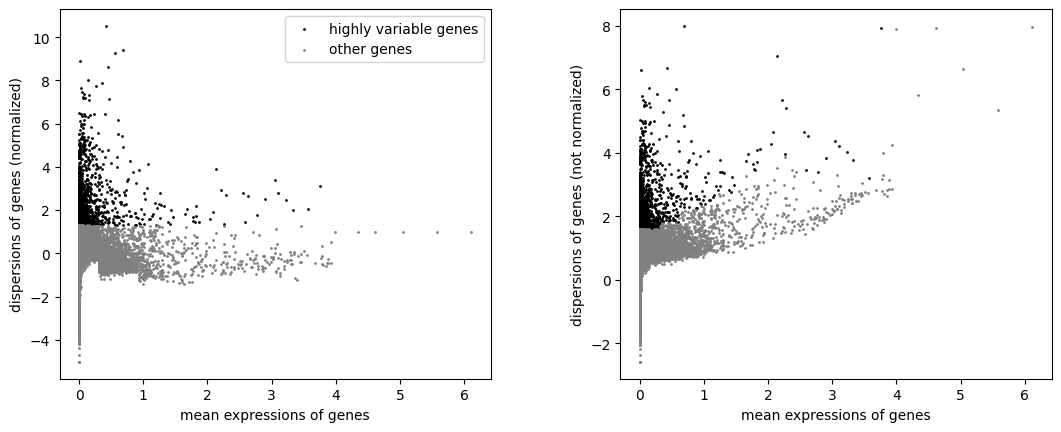

In [7]:
sc.pl.highly_variable_genes(adata)

In addition, to log-normalizing data it should be scaled before computing a PCA

In [8]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


For computing the PCA, we specify that we are limiting it to highly variable genes and give the number of PCs to be computed 

In [9]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:20)


The loadings of the PCs suggest genes which explain high variance among the single cell data

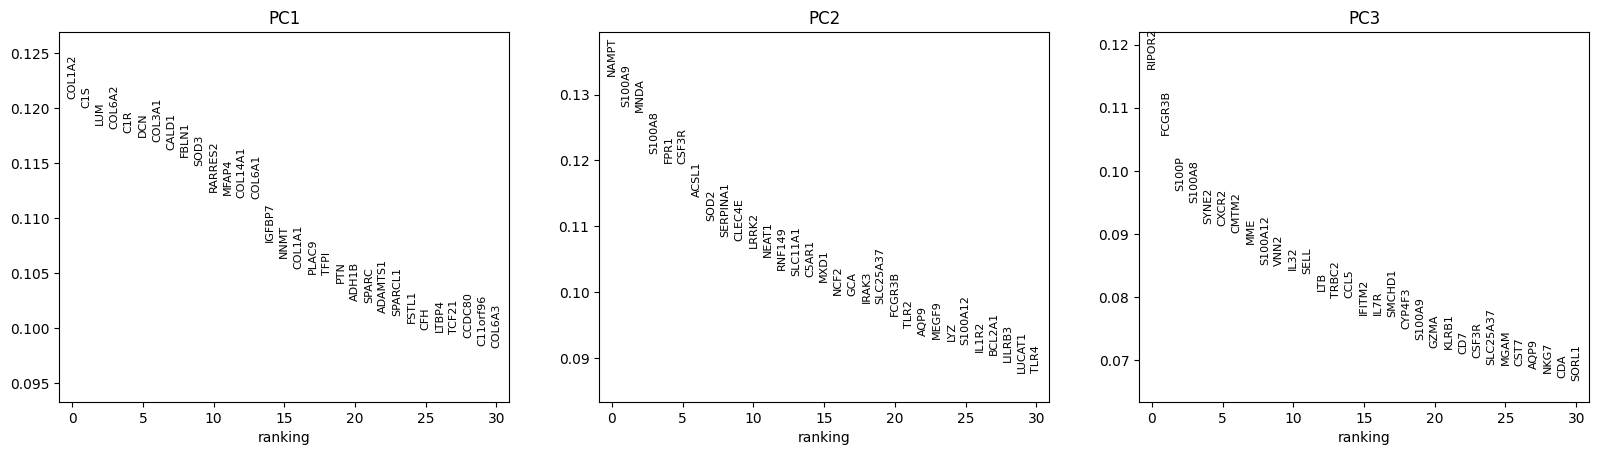

In [10]:
sc.pl.pca_loadings(adata, include_lowest=False)

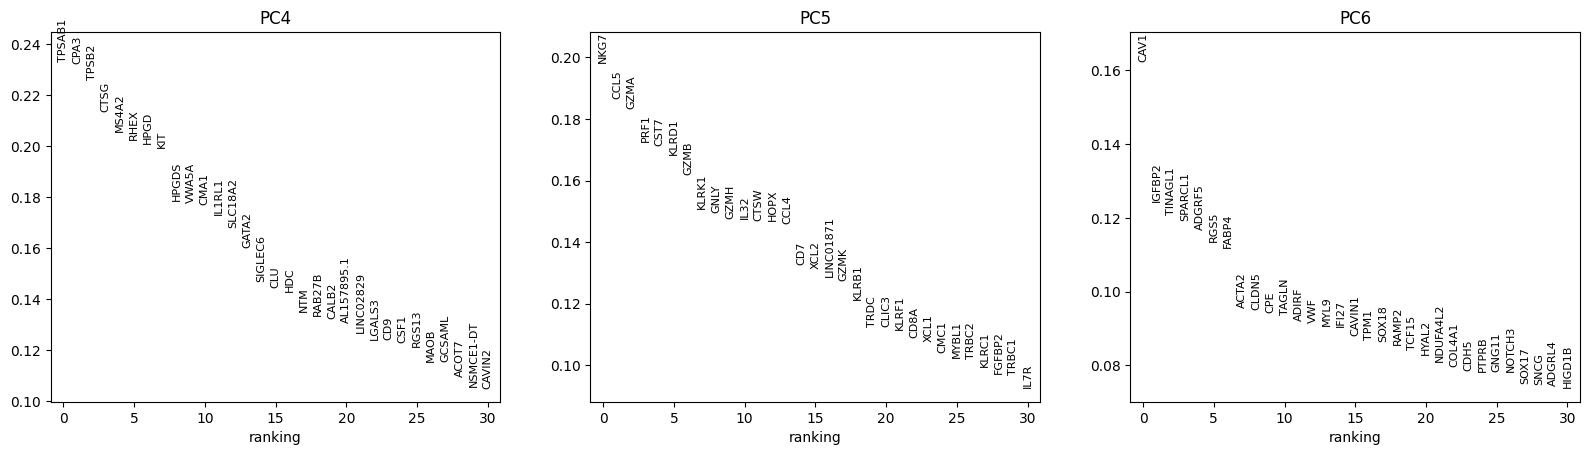

In [11]:
sc.pl.pca_loadings(adata, components='4,5,6', include_lowest=False)

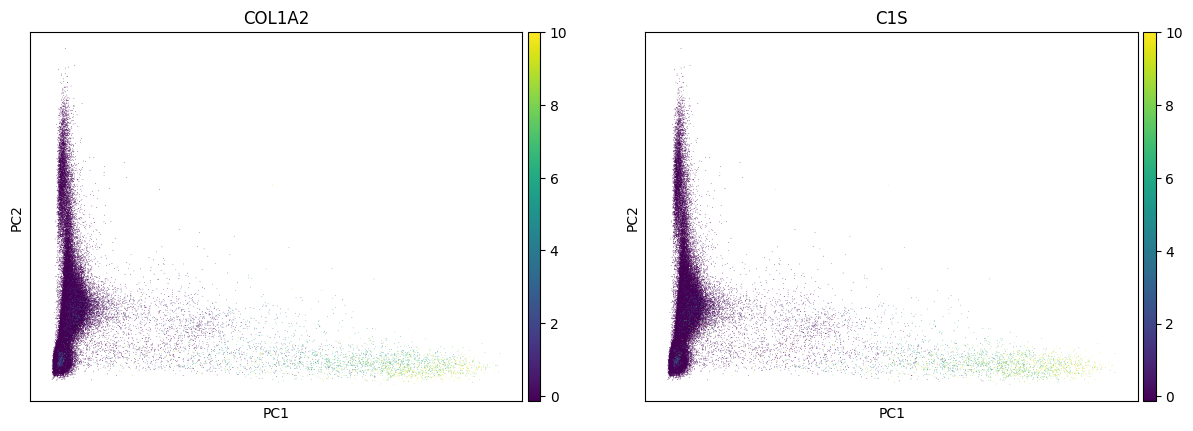

In [12]:
sc.pl.pca(adata, color=['COL1A2','C1S'])

For downstream steps such as computing embeddings and clusterings, we should limit the number of PCs. Using an elbow plot we can determine the PCs that show a high contribution to variance in our data. The first 30 PCs look like a reasonable choice.

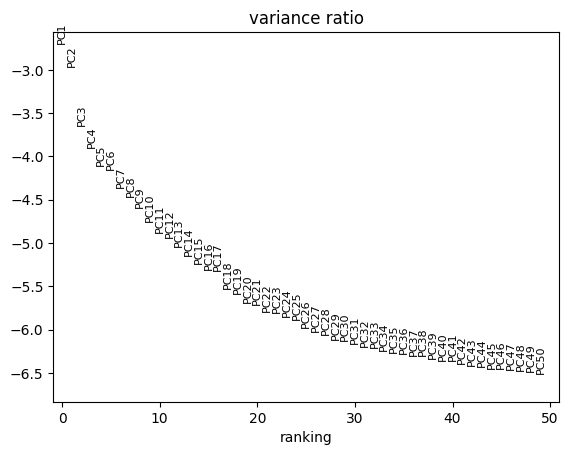

In [13]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

## Embeddings

To visualize single cell data in two dimensions, UMAP and tSNE are very useful embeddings. A UMAP uses a neighborhood graph that is computed based on PCs. This neighborhood graph will also be used for Leiden clustering.

In [14]:
sc.pp.neighbors(adata, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)


In [15]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:58)


On the UMAP we can that the genes with the highest loadings for the first 3 PCs are associated with distinct clusters.

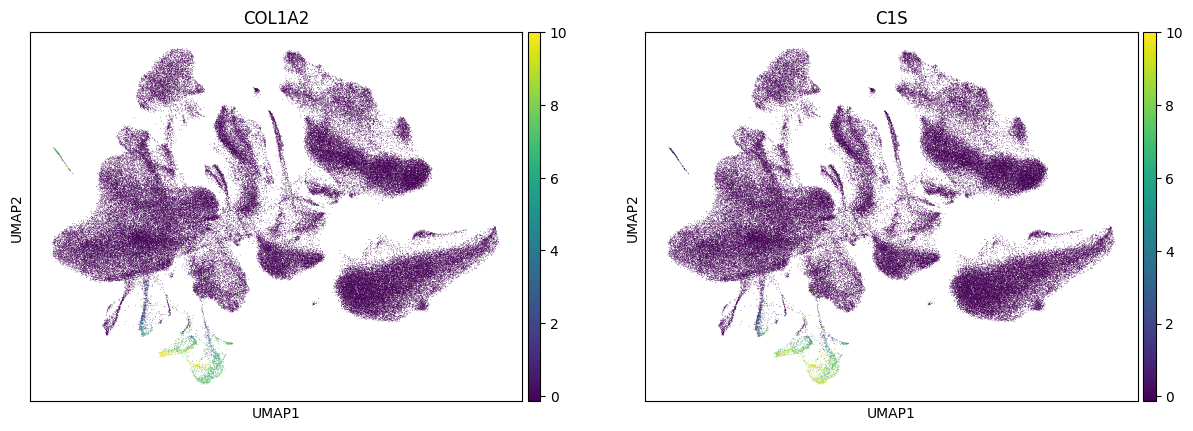

In [16]:
sc.pl.umap(adata, color=['COL1A2','C1S'])

Alternatively, we can compute a tSNE to visualize single cell data in 2D. Although UMAPs are generally better for capturing relationships between data points. tSNEs can provide a good view on distinct clusters.

In [50]:
sc.tl.tsne(adata, n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:03:47)


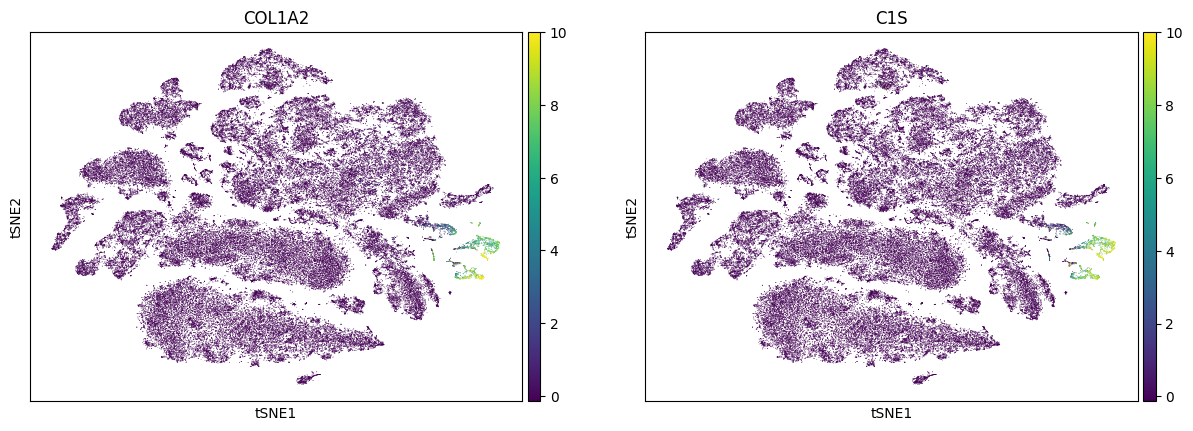

In [51]:
sc.pl.tsne(adata, color=['COL1A2','C1S'], use_raw=False)

UMAPs (or tSNEs) can also be useful to inspect biases in the data such as low and high counts, or where doublets are located. 

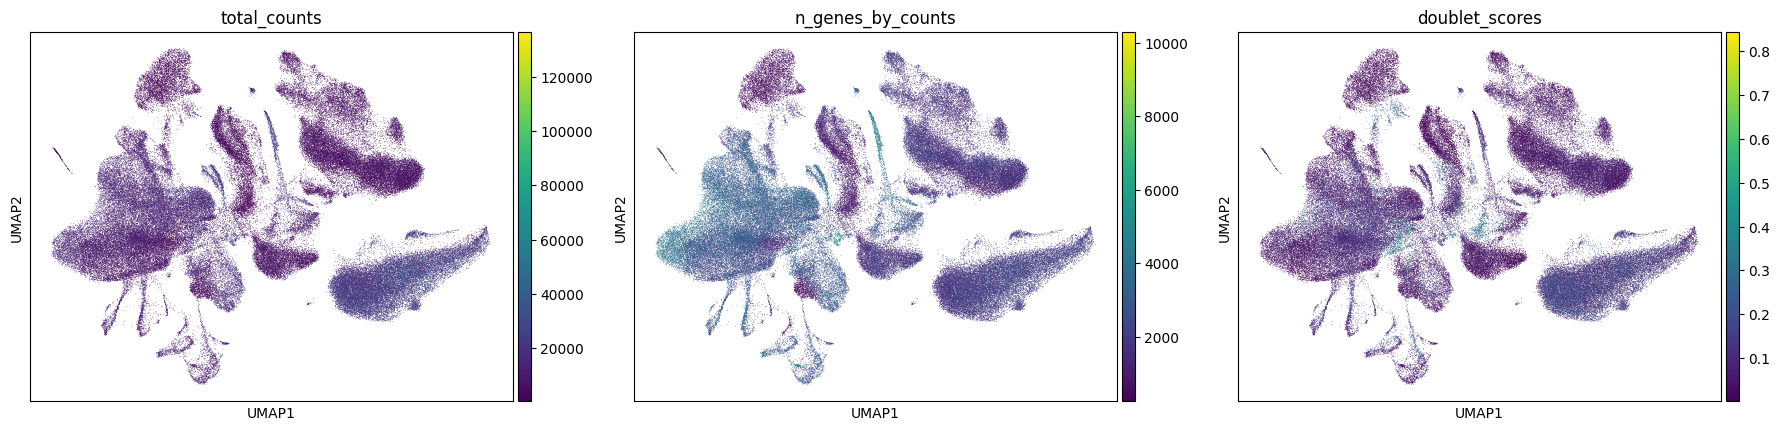

In [17]:
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts', 'doublet_scores'], use_raw=False)

## Clustering

Using the neighborhood graph that we computed above with `sc.pp.neighbors`, we can perform Leiden clustering to group single cells. This will be useful for identifying cell types. For Leiden clustering, a clustering resolution can be specified where higher values will result in more clusters.

In [18]:
sc.tl.leiden(adata, resolution=0.3)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:32)


/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


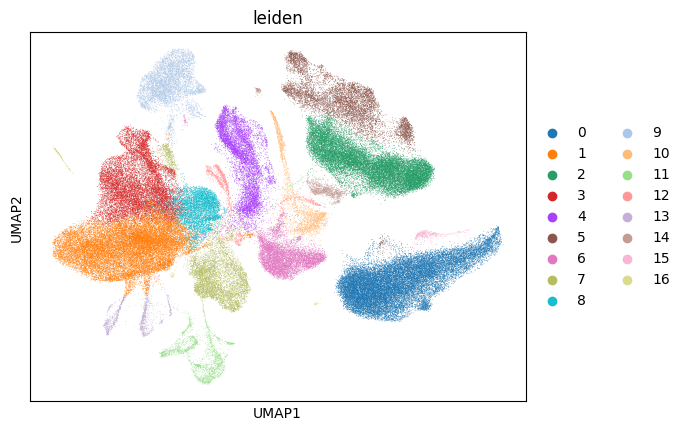

In [19]:
sc.pl.umap(adata, color=['leiden'])

Most of time, different clustering resolutions should be inspected depending on how fine or coarse grained the clustering of cells should be. We can automate this by looping over different resolutions and adding a key for each clustering resolution.

In [20]:
resolutions = [0.1, 0.3, 0.6, 1, 1.5, 2, 2.5, 3]

for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added='leiden_' + str(res) )

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:54)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:01:31)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:01:21)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden_1', the cluster labels (adata.obs, categorical) (0:02:42)
running Leiden clustering
    finished: found 43 clusters and added
    'leiden_1.5', the cluster labels (adata.obs, categorical) (0:03:11)
running Leiden clustering
    finished: found 52 clusters and added
    'leiden_2', the cluster labels (adata.obs, categorical) (0:02:20)
running Leiden clustering
    finished: found 59 clusters and added
    'leiden_2.5', the cluster labels (adata.obs, categorical) (0:02:23)
running Leiden clusterin

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


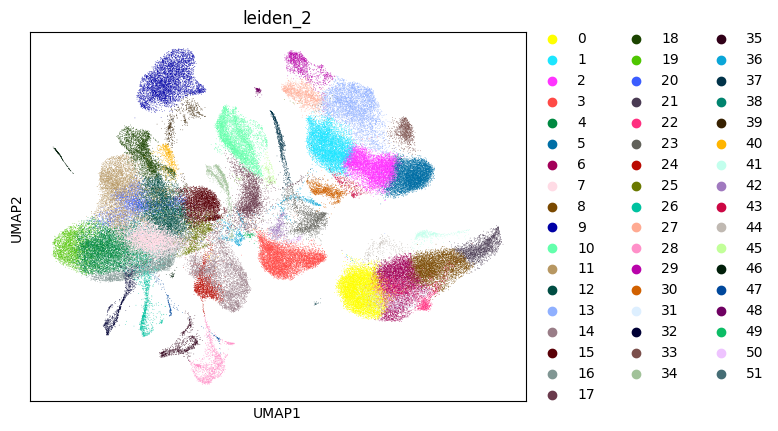

In [21]:
sc.pl.umap(adata, color=['leiden_2'])

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


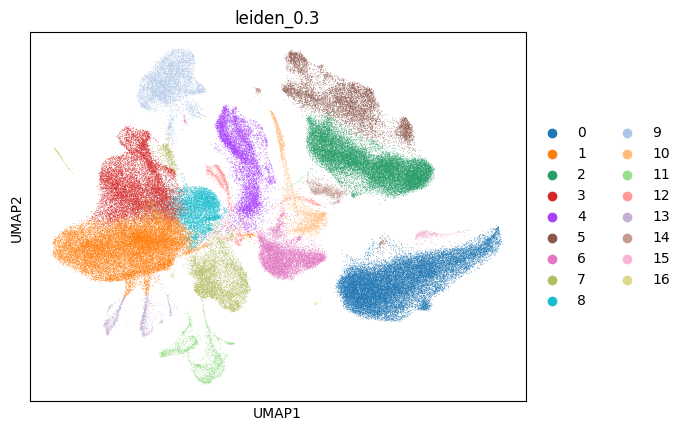

In [22]:
sc.pl.umap(adata, color=['leiden_0.3'])

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desire

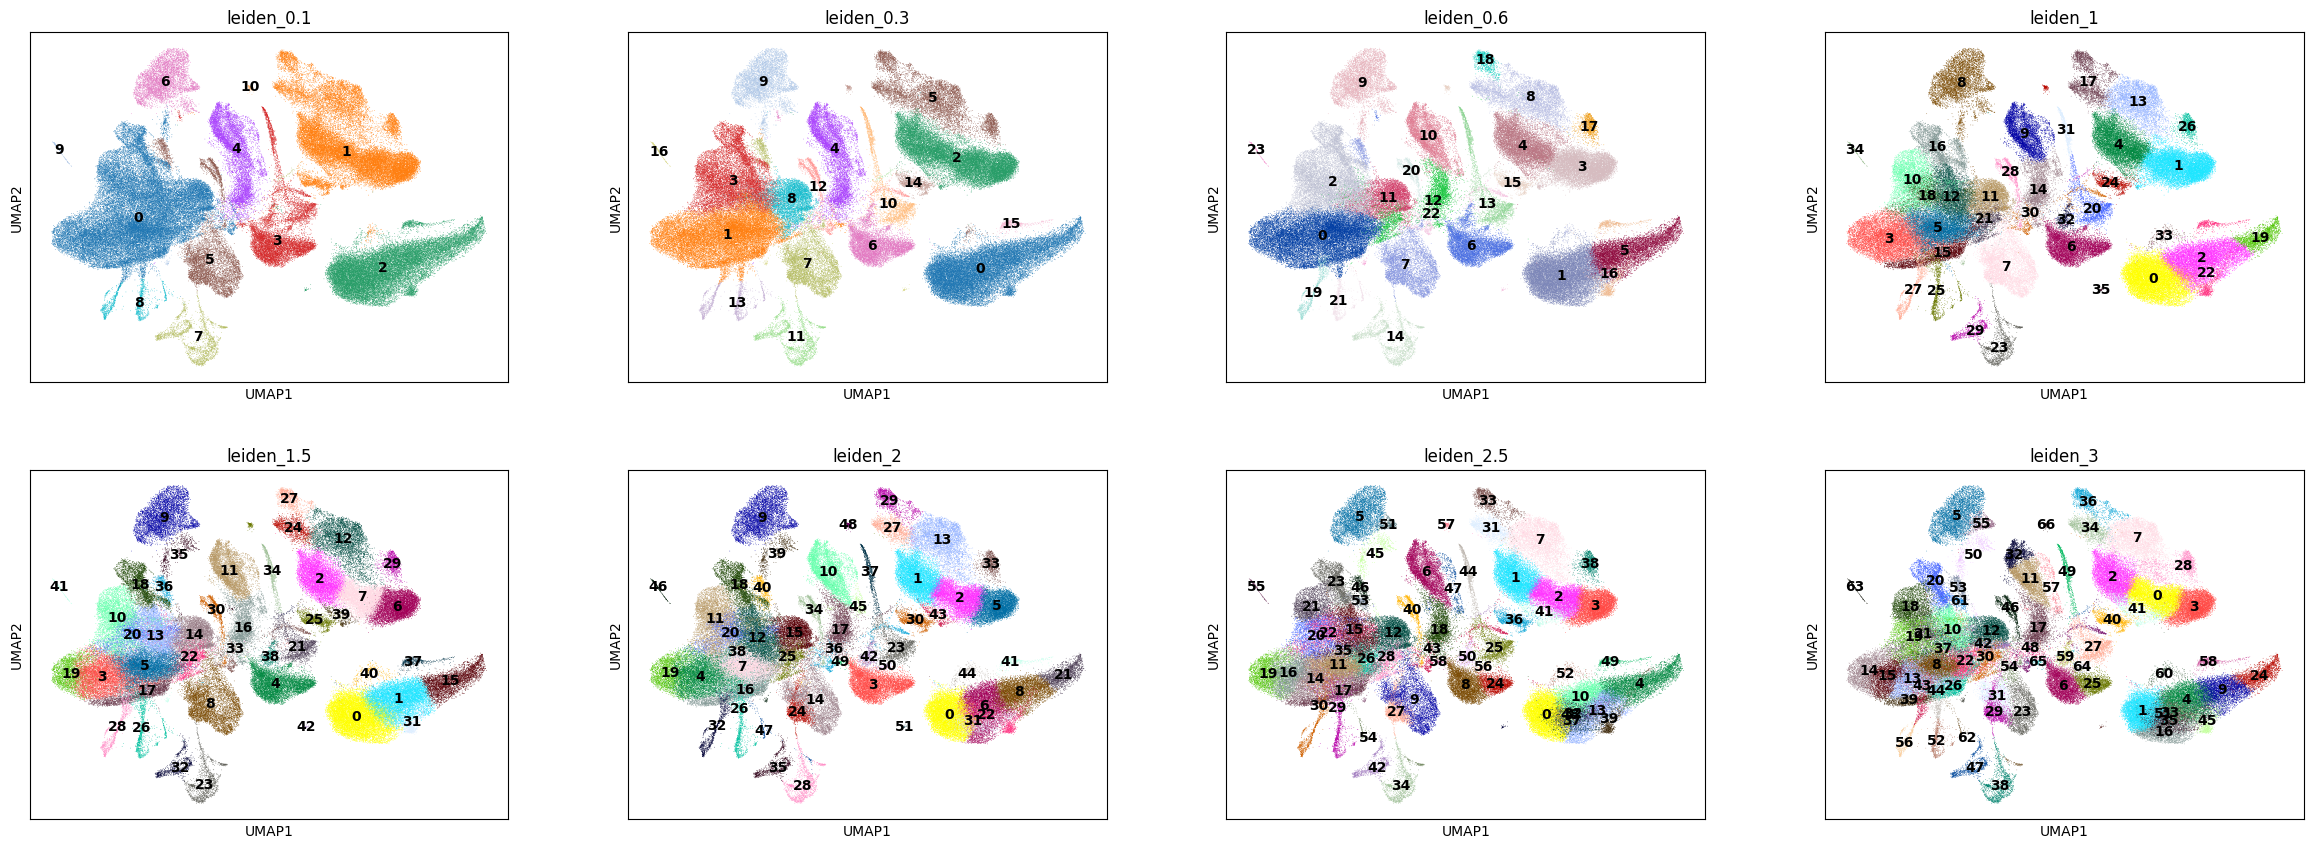

In [23]:
sc.pl.umap(
    adata,
    color=["leiden_0.1", "leiden_0.3", "leiden_0.6","leiden_1","leiden_1.5","leiden_2","leiden_2.5","leiden_3"],
    legend_loc="on data",
)

In [24]:
import os
adata.write(os.path.join("/media/gambino/students_workdir/ibp","/media/gambino/students_workdir/ibp/combined_clustered_normalizedpersampleglobal_qced_filtered_counts_13_11.h5"))

### Removing doublet clusters

In [2]:
import os
adata=anndata.read(os.path.join("/media/gambino/students_workdir/ibp","/media/gambino/students_workdir/ibp/combined_clustered_normalizedpersampleglobal_qced_filtered_counts_13_11.h5"))

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Rather than just removing doublets seperately based on a threshold, it can be useful to remove clusters with a high doublet fraction. This way we also capture cells that would just be above a doublet threshold.

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desire

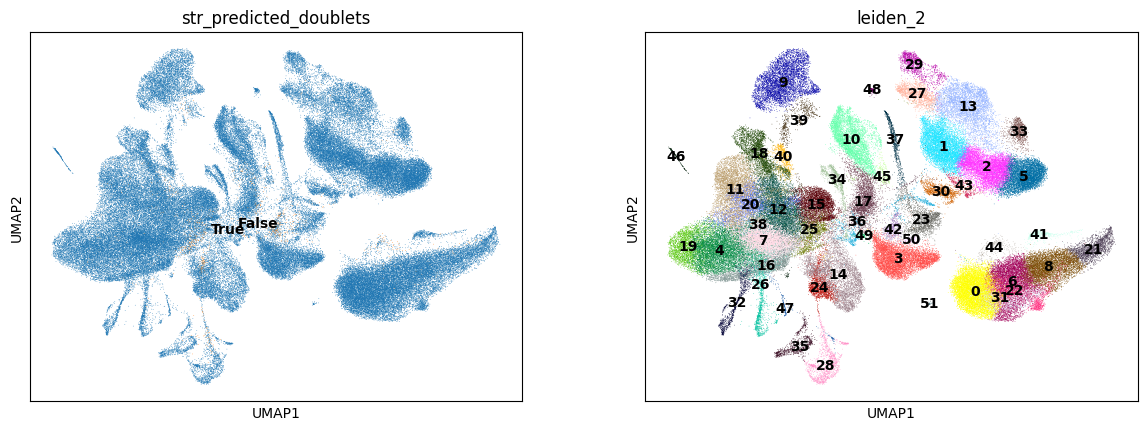

In [25]:
adata.obs['str_predicted_doublets'] = [str(dbl) for dbl in adata.obs['predicted_doublets']]
sc.pl.umap(adata, color=['str_predicted_doublets', 'leiden_2'], legend_loc='on data')

We can compute the fraction of doublets for each cluster using a rather high clustering resolution. This fraction can then be used to clean up our data before computing marker genes.

In [26]:
# what is fraction of doublets per cluster
import numpy as np
import pandas as pd

# init lists
list_clusters = np.unique(adata.obs['leiden_2'])
list_size = []
list_frac_doublets = []

# loop over clusters
for clus in list_clusters:
    clus_adata = adata[adata.obs['leiden_2'] == clus]
    
    size = clus_adata.shape[0]
    n_doublets = sum( clus_adata.obs['predicted_doublets'])
    
    list_frac_doublets.append( n_doublets / size )
    list_size.append(size)
    
df_frac_doublets = pd.DataFrame(
{
    'cluster': list_clusters,
    'size': list_size,
    'frac_doublets': list_frac_doublets
}
)

For a relatively strict filtering of doublet clusters, we could remove all clusters with a fraction of at least `0.3` doublets.

In [27]:
df_frac_doublets.sort_values('frac_doublets', ascending=False)

cluster  size  frac_doublets
37      42   466       0.321888
39      44   297       0.175084
44      49   106       0.160377
18      25  1464       0.159153
17      24  1489       0.059772
40      45   264       0.045455
16      23  1642       0.042022
33      39   647       0.038640
9       17  2941       0.032302
21      28  1301       0.028440
24      30  1163       0.014617
30      36   755       0.013245
29      35   839       0.013111
46      50    95       0.010526
35      40   583       0.010292
27      33   957       0.009404
38      43   340       0.008824
36      41   478       0.008368
43      48   123       0.008130
10      18  2800       0.007143
19      26  1455       0.006873
20      27  1327       0.006782
14      21  1974       0.006079
4       12  4635       0.005394
7       15  3851       0.005193
23       3  6271       0.005103
41      46   198       0.005051
6       14  4052       0.004936
28      34   928       0.004310
34       4  6082       0.004275
31      37   752       0.003989
3       11  4751       0.003578
15      22  1970       0.003553
22      29  1202       0.003328
26      32   973       0.003083
49       7  5599       0.003036
50       8  5136       0.002531
45       5  5933       0.002528
8       16  3258       0.002455
12       2  6342       0.002365
2       10  4793       0.002295
5       13  4388       0.002279
11      19  2527       0.001979
51       9  4905       0.001019
48       6  5634       0.000710
13      20  2318       0.000431
0        0  8344       0.000360
1        1  6513       0.000307
42      47   167       0.000000
32      38   684       0.000000
47      51    26       0.000000
25      31  1067       0.000000

We store the doublet cluster IDs in a list that we can use for filtering 

In [28]:
doublet_clusters = [ clus for clus 
                    in df_frac_doublets[ df_frac_doublets['frac_doublets'] >= 0.3 ]['cluster'] ]
doublet_clusters

['42']

You can remove the doublet clusters and doublet by subsessting the anndata object

In [29]:
adata = adata[ ~adata.obs['leiden_2'].isin(doublet_clusters) ].copy()
adata = adata[ adata.obs['predicted_doublets'] == False ].copy()
adata

AnnData object with n_obs × n_vars = 125326 × 36601
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'predicted_doublets', 'doublet_scores', 'leiden', 'leiden_0.1', 'leiden_0.3', 'leiden_0.6', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'str_predicted_doublets'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'leiden_2_colors', 'leiden_0.3_colors', 'leiden_0.1_colors', 'leiden_0.6_colors', 'leiden_1_colors', 'leiden_1.5_colors', 'leiden_2.5_colors', 'leiden_3_colors', 'str_predicted_doublets_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'
    obsp: 'distances', 'connectivities'

After removing doublets and clusters, the clusters should be recomputed

In [30]:
resolutions = [0.1, 0.3, 0.6, 1, 1.5, 2, 2.5, 3]

for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added='leiden_' + str(res) )

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:57)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:01:42)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:01:47)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden_1', the cluster labels (adata.obs, categorical) (0:03:10)
running Leiden clustering
    finished: found 42 clusters and added
    'leiden_1.5', the cluster labels (adata.obs, categorical) (0:03:52)
running Leiden clustering
    finished: found 53 clusters and added
    'leiden_2', the cluster labels (adata.obs, categorical) (0:02:58)
running Leiden clustering
    finished: found 61 clusters and added
    'leiden_2.5', the cluster labels (adata.obs, categorical) (0:02:22)
running Leiden clusterin

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desire

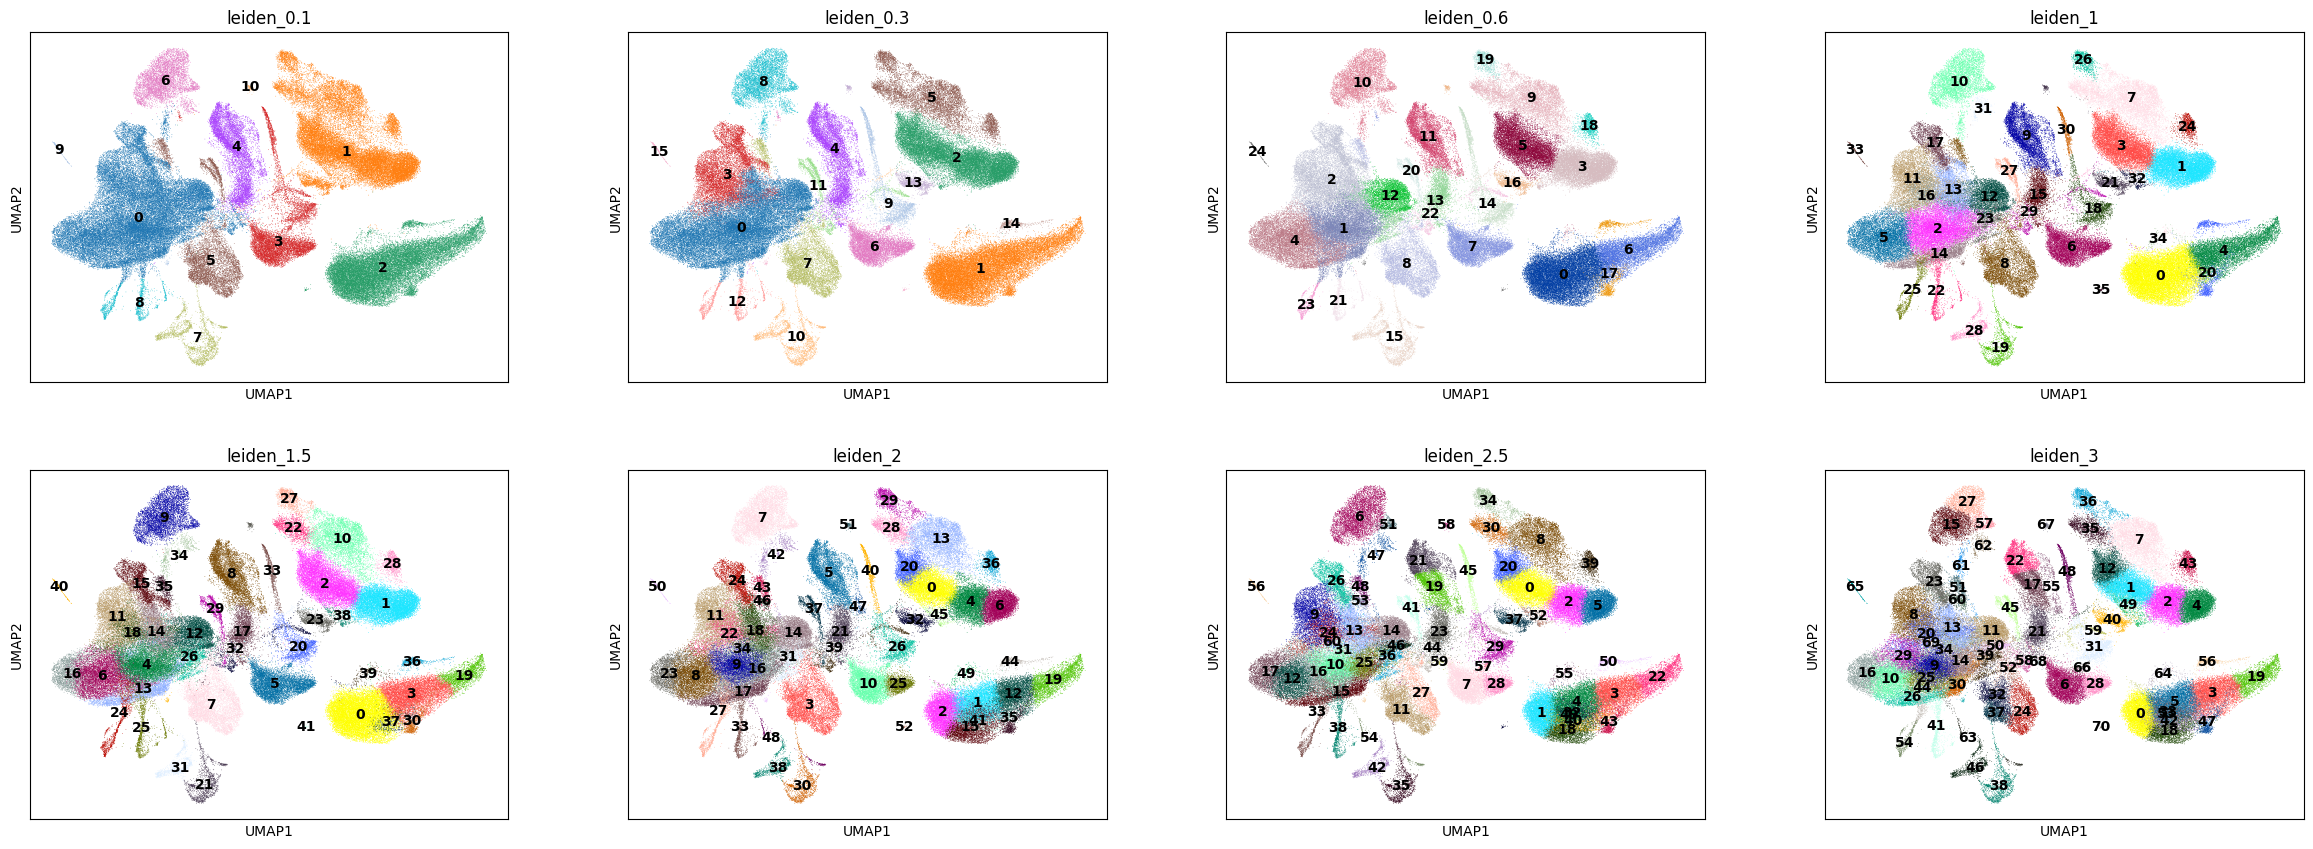

In [10]:
sc.pl.umap(
    adata,
    color=["leiden_0.1", "leiden_0.3", "leiden_0.6","leiden_1","leiden_1.5","leiden_2","leiden_2.5","leiden_3"],
    legend_loc="on data",
)

In [31]:
import os
adata.write(os.path.join("/media/gambino/students_workdir/ibp","/media/gambino/students_workdir/ibp/combined_nodoublets_clustered_normalizedpersampleglobal_qced_filtered_counts_2_12.h5"))